# Economic Distress Index
> A county-level measure of economic distress based on seven indicators.

- toc: true
- author: Nigel Soria
- badges: true
- categories: [census, acs, economic distress, counties]
- permalink: /distress-index/
- image: images/ks-edi.png

# Methodology

The index combines seven indicators into a single, comparative measure of economic well-being.  The index is constructed from the U.S. Census Bureau’s American Community Survey (ACS) 5-Year Estimates and County Business Patterns (CBP) datasets.

The seven components of the index are:

- no high school diploma—percent of the population 25 years of age and older without a high school diploma or equivalent;
- housing vacancy rate—percent of habitable housing that is unoccupied, excluding properties that are for seasonal, recreational, or occasional use;
- unemployment rate—the number of unemployed people as a fraction of the labor force;
- poverty rate—percent of the population living under the poverty line;
- median income ratio—median household income as a percent of the state’s median household income;
- change in employment—percent change in the number of jobs; and
- change in establishments—percent change in the number of business establishments. 

The counties are ranked on each of the seven indicators.  The index is calculated by taking the average of the seven rankings, which are equally weighted, and normalizing the average to be equivalent to a percentile.  Distress scores range from approaching zero to 100, such that a county with an average rank of 1,571 out of 3,142 will register a distress score of 50. 

**The County Maps:**

You can zoom and drag the maps with your mouse just like you would on Google Maps.  If you hover your mouse over a county, it will show you the county name and state, along with the following numbers:

- Distress Score:  These scores range from 0 to 100 and represent a percentile rank for that county.  Higher scores are bad.  For example, a score of 100 represents the most economically distressed county in the United States (i.e., with respect to the data I used).
- Distress Rank within U.S.:  This number shows how a county compares to other counties in the United States.  Unlike the distress score, lower numbers are bad, so a rank of 1 means that county is more distressed, on average, than any other county in the United States.
- Distress Rank within State:  This only considers counties within the same state.  For example, Johnson County has a rank of 105, which means it is the least distressed, on average, of the 105 counties in Kansas.

The colors on the map are based on the Distress Score, so gold = "good" and blue = "bad." 

**Notes Regarding the Data:**

The calculations present results for two time periods reflecting the composition and availability of the Census Bureau’s ACS 5-Year Estimates: 2013-2017 and 2014-2018. The 5-year estimates are constructed from five years’ worth of data collection, reflecting the length of time required to compile enough data to provide meaningful and accurate estimates at fine geographic scales, such as counties and zip codes. County Business Patterns data are available annually, and I chose to examine the years that match the ends of each ACS 5-year window.  For example, the change in employment represents the percent change in the number of jobs from 2017 to 2018.

In instances where employment or establishment estimates from the County Business Patterns data were not available for a particular county, I imputed the missing values using the average for the other counties in the same state. This only affected two counties in the United States.

In [17]:
#hide

import numpy as np
import pandas as pd
import requests
import scipy.stats as ss
import matplotlib as mpl
import json
import plotly.graph_objects as go
from urllib.request import urlopen
from IPython.display import Image, HTML

In [4]:
#hide_input

df18 = pd.read_csv('data/2018-rankings.csv', dtype={'fips':'str'})
df17 = pd.read_csv('data/2017-rankings.csv', usecols=['fips', 'pct_rank'], dtype={'fips':'str'}).\
    rename(columns={'pct_rank':'2017_rank'})
df = pd.merge(df18, df17, how='left', on='fips')
df['rank_chg'] = df['pct_rank'] - df['2017_rank']

dfc = pd.read_csv('data/state-centers.csv', encoding= 'unicode_escape')
df = pd.merge(df, dfc, how='left', on='state_name')

df.to_csv('data/distress-rankings.csv', index=False)

df.head()

In [5]:
#hide

def color_scale(c1, c2, n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    colors = []
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))

    for x in range(n+1):
        color = mpl.colors.to_hex((1-x/n)*c1 + x/n*c2)
        colors.append(color)

    return colors

ks_gold ='#F1AD02'
ks_blue ='#002569'
n=500
colors = color_scale(ks_gold, ks_blue, n)

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)    

# Economic Distress Scores for U.S. Counties

Click [here](https://sokansas-my.sharepoint.com/:u:/g/personal/nigel_soria_kdc_ks_gov/EWJwCfTD1PFDuLB89tDL01YBEQpSwl82I278uhkfc6eCfQ?e=6DLzMr) to download an interactive version of the U.S. map.  Click [here](https://sokansas-my.sharepoint.com/:x:/g/personal/nigel_soria_kdc_ks_gov/EX_2QHPjlEtMmgWUF26AjOwBfA-x0T_0Jqv4RXnMoRnfcg?e=SYgXfn) to access the data used to create both maps.

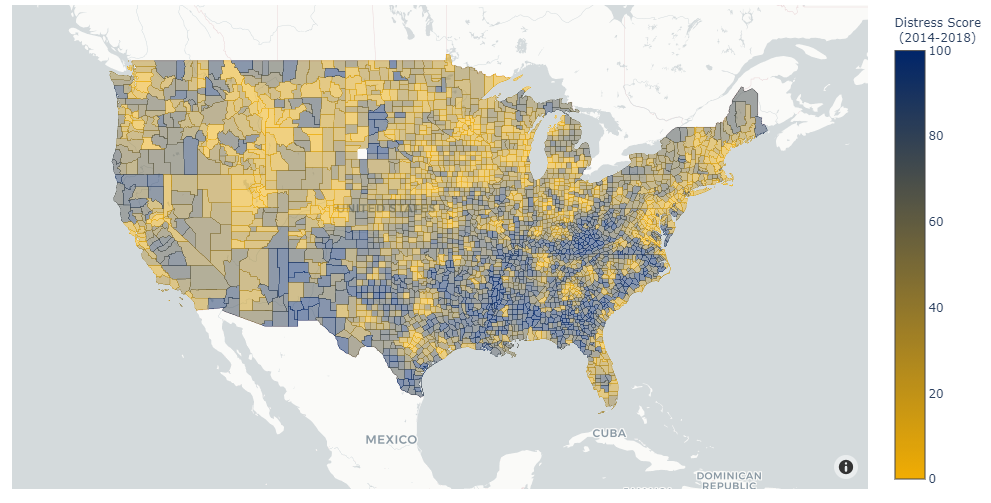

In [19]:
#hide

df = pd.read_csv('../data/distress-rankings.csv', dtype={'fips':'str'})

fig = go.Figure(go.Choroplethmapbox(geojson=counties, locations=df['fips'], z=df['pct_rank'],
                                    colorscale=colors, zmin=0, zmax=100,
                                    marker_opacity=0.5, marker_line_width=0,
                                    text='County:  ' + df['county'].str.title() +
                                    '<br>State:  ' + df['state_name'] + 
                                    '<br>Distress Score (2014-2018):   ' + df['pct_rank'].round(1).astype(str) +
                                    '<br>Distress Score (2013-2017): ' + df['2017_rank'].round(1).astype(str) +
                                    '<br>Change in Distress Score:  ' + df['rank_chg'].round(1).astype(str) +
                                    '<br>Distress Rank within U.S. (2014-2018):  ' + df['us_rank'].astype(int).map(lambda x: '{:,}'.format(x)).astype(str) + 
                                    ' / ' + '{:,}'.format(df.shape[0]) +
                                    '<br>Distress Rank within State (2014-2018):  ' + df['st_rank'].astype(int).map(lambda x: '{:,}'.format(x)).astype(str) +
                                    ' / ' + df['counties'].astype(str),
                                    hoverinfo='text',
                                    colorbar={'title':'Distress Score <br> (2014-2018)'}
                                   ))
fig.update_layout(mapbox_style='carto-positron',
                  mapbox_zoom=3, mapbox_center={'lat': 37.0902, 'lon': -95.7129})
fig.update_layout(margin={'r':0,'t':0,'l':0,'b':0})

fig.show()

In [ ]:
#hide_input

HTML(fig.to_html(include_plotlyjs='cdn'))

# Economic Distress Scores for Kansas Counties

Click [here](https://sokansas-my.sharepoint.com/:u:/g/personal/nigel_soria_kdc_ks_gov/EXroEBW6FcZHopjiij-8NTUB496oibwj-FvhVFCZQYQPyg?e=WXyPvh) to download an interactive version of the Kansas-specific map.

In [1]:
#hide

state = 'Kansas'
    
fmask = df['state_name']==state

fig = go.Figure(go.Choroplethmapbox(geojson=counties, locations=df[fmask]['fips'], z=df[fmask]['pct_rank'],
                                    colorscale=colors, zmin=0, zmax=100,
                                    marker_opacity=0.5, marker_line_width=0,
                                    text='County:  ' + df[fmask]['county'].str.title() +
                                    '<br>State:  ' + df[fmask]['state_name'] + 
                                    '<br>Distress Score (2014-2018):   ' + df[fmask]['pct_rank'].round(1).astype(str) +
                                    '<br>Distress Score (2013-2017): ' + df[fmask]['2017_rank'].round(1).astype(str) +
                                    '<br>Change in Distress Score:  ' + df[fmask]['rank_chg'].round(1).astype(str) +
                                    '<br>Distress Rank within U.S. (2014-2018):  ' + df[fmask]['us_rank'].astype(int).map(lambda x: '{:,}'.format(x)).astype(str) + 
                                    ' / ' + '{:,}'.format(df.shape[0]) +
                                    '<br>Distress Rank within State (2014-2018):  ' + df[fmask]['st_rank'].astype(int).map(lambda x: '{:,}'.format(x)).astype(str) +
                                    ' / ' + df[fmask]['counties'].astype(str),
                                    hoverinfo='text',
                                    colorbar={'title':'Distress Score <br> (2014-2018)'}
                                   ))
fig.update_layout(mapbox_style='carto-positron',
                  mapbox_zoom=6, mapbox_center = {'lat': df[fmask]['lat'].iloc[0], 'lon': df[fmask]['lon'].iloc[0]})
fig.update_layout(margin={'r':0,'t':0,'l':0,'b':0})

fig.show()

NameError: name 'df' is not defined

In [ ]:
#hide_input

HTML(fig.to_html(include_plotlyjs='cdn'))